Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - accuracy: 0.7333 - dice_coef: 0.2221 - iou_score: 0.1828 - loss: 0.7403 - val_accuracy: 0.9418 - val_dice_coef: 0.1300 - val_iou_score: 0.0806 - val_loss: 1.2650 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.9616 - dice_coef: 0.3306 - iou_score: 0.2848 - loss: 0.1588 - val_accuracy: 0.8796 - val_dice_coef: 0.1797 - val_iou_score: 0.1260 - val_loss: 0.9066 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.9700 - dice_coef: 0.4079 - iou_score: 0.3407 - loss: 0.1024 - val_accuracy: 0.8575 - val_dice_coef: 0.2256 - val_iou_score: 0.1722 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.9728 - dice_coef: 0.4423 - iou_score: 0.3646 - loss: 0.0830 - val_accuracy: 0.8918 - val_

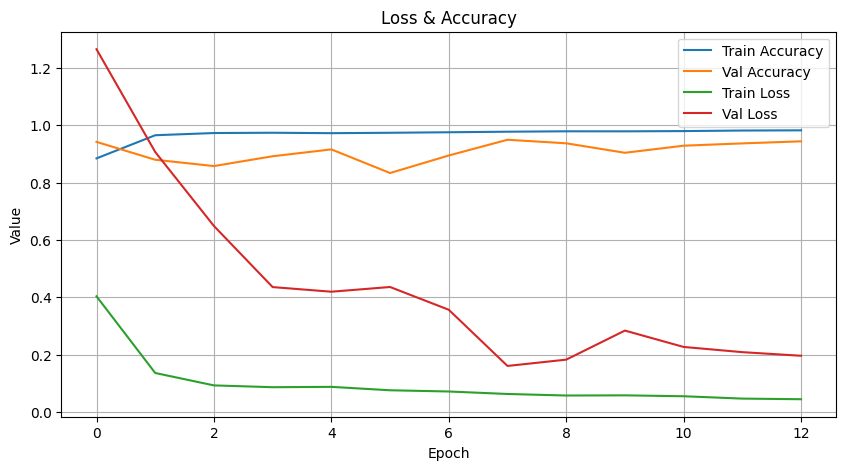

In [5]:
# Script: 3acl_training.py
# Purpose: Train a memory-efficient 3ACL model using a data generator on sampled_128

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

# -------------------------------
# 1. MOUNT GOOGLE DRIVE
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/sampled_128"

# -------------------------------
# 2. DATA GENERATOR with DOWNSAMPLING
# -------------------------------
class VolumeDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, shuffle=True):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.npy')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.npy')))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_img_paths]  # downsample
        masks = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_mask_paths]  # downsample

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(temp)
            self.image_paths, self.mask_paths = zip(*temp)

# -------------------------------
# 3. 3ACL-STYLE MODEL
# -------------------------------
def unet_3acl(input_shape=(64,64,64,3), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv3D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = layers.Conv3D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = layers.Conv3D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    # Bridge
    b = layers.Conv3D(128, 3, activation='relu', padding='same')(p3)
    b = layers.BatchNormalization()(b)

    # Decoder with simulated attention (3ACL-style) and channel alignment
    u3 = layers.UpSampling3D((2,2,2))(b)
    u3 = layers.Conv3D(64, 1, padding='same')(u3)
    m3 = layers.Multiply()([u3, c3])
    d3 = layers.Conv3D(64, 3, activation='relu', padding='same')(m3)

    u2 = layers.UpSampling3D((2,2,2))(d3)
    u2 = layers.Conv3D(32, 1, padding='same')(u2)
    m2 = layers.Multiply()([u2, c2])
    d2 = layers.Conv3D(32, 3, activation='relu', padding='same')(m2)

    u1 = layers.UpSampling3D((2,2,2))(d2)
    u1 = layers.Conv3D(16, 1, padding='same')(u1)
    m1 = layers.Multiply()([u1, c1])
    d1 = layers.Conv3D(16, 3, activation='relu', padding='same')(m1)

    outputs = layers.Conv3D(n_classes, 1, activation='softmax')(d1)
    model = models.Model(inputs, outputs)
    return model

# -------------------------------
# 4. METRICS
# -------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth))
    return dice

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    total = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    union = total - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth))
    return iou

# -------------------------------
# 5. TRAINING
# -------------------------------
train_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'train/images'),
    mask_dir=os.path.join(data_path, 'train/masks'),
    batch_size=1
)

val_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'val/images'),
    mask_dir=os.path.join(data_path, 'val/masks'),
    batch_size=1
)

model = unet_3acl(input_shape=(64,64,64,3), n_classes=4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coef, iou_score])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=callbacks)

# -------------------------------
# 6. FINAL METRICS + COMBINED PLOT
# -------------------------------
final_metrics = model.evaluate(val_gen, verbose=0)
print(f"\nFinal Validation Metrics:")
print(f"Loss:         {final_metrics[0]:.4f}")
print(f"Accuracy:     {final_metrics[1]:.4f}")
print(f"Dice Coef:    {final_metrics[2]:.4f}")
print(f"IoU Score:    {final_metrics[3]:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
